In [2]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [3]:
using_colab = True

In [4]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    from google.colab import drive
    from tqdm import tqdm
    drive.mount('/content/drive')

PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: True
Mounted at /content/drive


In [5]:
if using_colab:
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    
    !mkdir images
    # !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-q_dbmf33
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-q_dbmf33
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=ffb1d8db0a09704f0c892269166a0baf0cabbaff67e5ab3b2e1efffd9e9182d5
  Stored in directory: /tmp/pip-ephem-wheel-cache-jmtl0vx0/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-05-17 03:00:47--  https://dl.fbaipublicfiles.com/segment_anything/s

## Import file

Add file directory for the analyzed image and directory for storing intermediate files.

In [494]:
image_name = "2ae3e6e6-7482-4ab8-ad73-b530b5c2ee3b.png"
root_path = "/content/drive/MyDrive/bdd/Colab Notebooks/" # change this to your own directory
image_path = root_path + image_name
cell_path = root_path + 'SAM_cell/'
shap_image_path = root_path + 'Shap_image/'
pt_path = root_path
JSON_path = root_path + 'JSON/'

In [495]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
from tqdm import tqdm
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import itertools
import matplotlib.patches as patches
from torchvision import transforms
from PIL import Image
from itertools import combinations 
import math



In [496]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

In [498]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [499]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [500]:
'''
  perform SAM on a single image
  input: 
    image: (# of rows, # of colns, # of channels)
  output: 
    SAM_matrix: (bbox_h_max, bbox_w_max, # of channels, # of masks)
'''
def SAM_Image(image):
  segmentation_list = []
  bbox_list = []
  masks = mask_generator.generate(image)
  num_masks = len(masks)
  num_masks = len(masks)
  w_list = []
  h_list = []
  for n in range(num_masks):
    _,_,w, h = masks[n]['bbox']
    w_list.append(w)
    h_list.append(h)
  w_std, h_std = np.std(np.array(w_list)), np.std(np.array(h_list))
  w_mean, h_mean = np.mean(np.array(w_list)), np.mean(np.array(h_list))
  w_max = int(w_mean+w_std)
  h_max = int(h_mean+h_std)
  image_y, image_x, channels = image.shape
  SAM_list = []
  for n in tqdm(range(num_masks)):
    if masks[n]['bbox'][2] < w_mean+w_std and masks[n]['bbox'][3] < h_mean+h_std :
      bbox_list.append(masks[n]['bbox'])
      segmented_image = np.zeros((image_y, image_x, channels), 'uint8')
      masks_segmentation_matrix = np.zeros((image_y, image_x), 'uint8')
      masks_segmentation_matrix[masks[n]['segmentation'] == True] = 1
      masks_segmentation_matrix[masks[n]['segmentation'] == False] = 0
      segmentation_list.append(masks_segmentation_matrix)
      for c in range(channels):
        segmented_image[:,:,c] =  masks_segmentation_matrix*image[:,:,c]
      x_bbox, y_bbox, w_bbox, h_bbox = masks[n]['bbox']
      if y_bbox+h_max < image_y and x_bbox+w_max < image_x :
        single_cell = segmented_image[y_bbox:y_bbox+h_max,x_bbox:x_bbox+w_max, :]
      elif y_bbox+h_max >= image_y and x_bbox+w_max < image_x:
        single_cell = segmented_image[-(h_max):,x_bbox:x_bbox+w_max, :]
      elif y_bbox+h_max < image_y and x_bbox+w_max >= image_x:
        single_cell = segmented_image[y_bbox:y_bbox+h_max,-(w_max):, :]
      elif y_bbox+h_max >= image_y and x_bbox+w_max >= image_x:
        single_cell = segmented_image[-(h_max):,-(w_max):, :]
      SAM_list.append(single_cell.flatten())
  return np.array(SAM_list), segmentation_list, bbox_list

In [501]:
def PCA_KMeans(image_flatten):
  """Run pca and kmeans on flattened images
  :param image_flatten: numpy array contain flattened images
  :return: lables of kmeans
  """
  # pca
  pca = PCA(n_components=0.72)
  pca.fit(image_flatten)
  pca_images = pca.transform(image_flatten)
  # kmeans
  kmeans = KMeans(n_clusters=4)
  kmeans.fit(pca_images)
  return kmeans.labels_

In [502]:
def kmeans_image_color_mapping(K_Means_center_assignment_list, image):
  """Assign different colors to different cluster on image
  :param K_Means_center_assignment_list: kmeans label
  :param image: original image
  :return: colored image
  """
  image_copy = image.copy()
  for i, center in enumerate(K_Means_center_assignment_list): 
    segment_matrix = segmentation_list[i]
    legend_list = []
    if center == 0:
      assign_Color = np.array([255,0,0])
      if 'red' not in legend_list:
        legend_list.append('red')
    elif center == 1: 
      assign_Color = np.array([0,255,0])
      if 'green' not in legend_list:
        legend_list.append('green')
    elif center == 2: 
      assign_Color = np.array([0,0,255])
      if 'blue' not in legend_list:
        legend_list.append('blue')
    elif center == 3:
      assign_Color = np.array([255,255,0])
      if 'yellow' not in legend_list:
        legend_list.append('yellow')
    image_copy[segment_matrix == 1,:] = assign_Color
  plt.legend(legend_list)
  plt.imshow(image_copy)
  
  return image_copy

In [503]:
"""
A Convolutional Variational Autoencoder for generating fake cell
"""
class ConvolutionalVAE(nn.Module):
    def __init__(self, imgChannels=3, featureDim=32*116*116, zDim=20):
        super(ConvolutionalVAE, self).__init__()

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 7)
        self.encConv2 = nn.Conv2d(16, 32, 7)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)
        self.flatten = nn.Flatten()

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 7)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 7)

    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 32*116*116)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 32, 116, 116)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

In [504]:
# load the trained VAE model

order_dict = torch.load(pt_path+"vae_cell_conv.pt", map_location=device)
model = ConvolutionalVAE(imgChannels=3)
model.load_state_dict(order_dict)
model.to(device)

def patch_cell_with_VAE(image, bbox):
    """Patch cell at bbox using VAE

    :param image: cv2 image
    :param bbox: (x,y,w,h) bounding box of size (y: y+h, x: x+w)
    :return:
    """
    x,y,w,h = bbox[0], bbox[1], bbox[2], bbox[3]
    original_patch = cv2.resize(image[y:y+h, x:x+w], (128, 128))
    original_patch = original_patch/255
    original_patch = original_patch.transpose(2, 0, 1)
    original_patch = original_patch.reshape((1,3,128,128))
    out, mu, logVAR = model(torch.tensor(original_patch).float().to(device))
    outimg = out.detach().to('cpu').numpy().reshape((3, 128, 128))
    outimg = np.array(outimg.transpose(1,2,0) * 255, dtype="uint8")
    cell_image = cv2.resize(outimg, (w, h))
    # print('----- in patch_cell_with_VAE')
    # print(bbox)
    # print(cell_image.shape)
    # patched_image = image
    # print(patched_image[y:y + h, x:x + w].shape)

    image[y:y + h, x:x + w] = cell_image
    return image

In [505]:
def patch_clustered_cells_with_VAE(image, bbox, cluster_assignment_list, cluster_excluded_list):
  """Patch cell with VAE
  :param image: numpy array image
  :param bbox: list of bboxes
  :param cluster_assignment_list: list contains that cluster centroid id (result of kmeans)
  :param cluster_excluded_list: list of excluded clusters
  :return: patched cell image
  """
  # all_list = list(range(num_clusters))
  '''
  bbox - list
  '''
  image_name = 'output_'
  image_copy = image.copy()
  bbox_array = np.array(bbox)
  cluster_array = np.array(cluster_assignment_list)
  print(cluster_excluded_list)
  if len(cluster_excluded_list) == 0:
    image_name = image_name
    plt.imsave(shap_image_path+image_name+'.png', image_copy)
  else:
    for cluster_excluded in cluster_excluded_list:
      image_name = image_name+str(cluster_excluded+1)
      bbox_one_cluster_all = bbox_array[cluster_array == cluster_excluded,:]
      for i in range(bbox_one_cluster_all.shape[0]):
        image_copy = patch_cell_with_VAE(image_copy, bbox_one_cluster_all[i,:])
    plt.imsave(shap_image_path+image_name+'.png', image_copy)
      
  return image_copy


In [506]:
def plot_sick_cell(f, image):
  """Plot the image with bounding box of sick cell (ground truth)

  :param f: json file contains the ground truth sick cell position
  :param image: numpy array image
  :return: None
  """
  a = None
  data = json.load(f)
  for i in range(len(data)):
      if image_name in data[i]["image"]["pathname"]:
          a = data[i]
  bbx = []
  if a != None: 
    for i in range(len(a["objects"])):
        if a["objects"][i]["category"] != "red blood cell":
            print(a["objects"][i])
            x = a["objects"][i]["bounding_box"]["minimum"]["c"]
            y = a["objects"][i]["bounding_box"]["minimum"]["r"]
            w = a["objects"][i]["bounding_box"]["maximum"]["c"] - a["objects"][i]["bounding_box"]["minimum"]["c"]
            h = a["objects"][i]["bounding_box"]["maximum"]["r"] - a["objects"][i]["bounding_box"]["minimum"]["r"]
            bbx.append([x, y, w, h])
    for c in bbx:
        x, y, w, h = c
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    plt.imshow(image)

In [507]:
def shap_value_image_generation(image, bbox, cluster_assignment_list, cluster_excluded_all_list):
  """Generate intermediate files for shapley value calculation

  :param image: analzyed image
  :param bbox: list of bbox
  :param cluster_assignment_list: list contains that cluster centroid id (result of kmeans)
  :param cluster_excluded_all_list: list of cluster_excluded_list
  :return:
  """
  for cluster_excluded_list in cluster_excluded_all_list:
    _ = patch_clustered_cells_with_VAE(image, bbox, cluster_assignment_list, cluster_excluded_list)

In [508]:
def excluded_list_generation(num_of_players):
  """Generate list of combination of players based on num_of_player
  :param num_of_players: integer representing number of player
  :return: combination
  """
  numbers = list(range(num_of_players))
  combinations = []
  for r in range(len(numbers)+1):
      for combination in itertools.combinations(numbers, r):
          combinations.append(list(combination))
  return combinations

In [509]:
def get_model_result(image, model):
    """Return binary classifier result of a model
    :param image: image to be analyzed
    :param model: pytorch classifier model
    :return: probability of being class 1
    """
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    transform = transforms.Compose(
        [transforms.ToTensor(), 
        transforms.Normalize(mean=mean, std=std),
        ]
    )
    prep_img = transform(image).to(device)
    prep_img = torch.unsqueeze(torch.tensor(prep_img).float(), 0)
    prob_scores = model(prep_img).cpu().detach().numpy()[0]
    p = prob_scores[1]
    return p

In [510]:
# Code for Shapley value calculation
def exclude_k_matrics_calculation(k,directory, M, model):
    exclude_player2_list = []
    exclude_player2_team_index_list = []
    player_list = []
    probList = []
    contains_player2_list = []
    contains_player2_team_index_list = []
    team_index = 0 
    all_players = list(range(1,M+1))

    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    transform = transforms.Compose(
        [transforms.ToTensor(), 
        transforms.Normalize(mean=mean, std=std),
        ]
    )
    
    for filename in os.listdir(directory):
            f = os.path.join(directory, filename)
            # checking if it is a file
            if os.path.isfile(f) and f[-4:] == '.png' and "output" in filename:
                ext = filename[7:-4] # if large 16 if small 7
                # print(ext)
                players_excluded = list(ext)
                players_excluded = [int(i) for i in players_excluded]
                players = all_players.copy()
                for excludedPalyerId in players_excluded: 
                    players.remove(excludedPalyerId)
                if k in players:
                    # print("--- Ture")
                    contains_player2_list.append(players)
                    contains_player2_team_index_list.append(team_index)
                else: 
                    # print("--- False")
                    exclude_player2_list.append(players)
                    exclude_player2_team_index_list.append(team_index)
                player_list.append(players)
                image = Image.open(directory+"/"+filename).convert('RGB')
                image_t = image
                print(image_t)
                prep_img = transform(image_t).to(device)
                
                prep_img = torch.unsqueeze(torch.tensor(prep_img).float(), 0)
                prob_scores = model(prep_img).cpu().detach().numpy()[0]
                p = prob_scores[1]
                probList.append(p)
                team_index += 1
    return exclude_player2_list, exclude_player2_team_index_list, player_list, probList, contains_player2_list, contains_player2_team_index_list


    #%% calcualte shaply
def shap_k_calulation(k, exclude_playerk_list, exclude_playerk_team_index_list, player_list, probList, contains_playerk_list, contains_playerk_team_index_list, M):
    shap_k = 0
    for i, teams_withk in enumerate(contains_playerk_list):
        
        teams_withoutk = teams_withk.copy()
        teams_withoutk.remove(k)
        subset_size = len(teams_withoutk)
        prob_excluded = probList[exclude_playerk_team_index_list[exclude_playerk_list.index(teams_withoutk)]]
        # print("---")
        # print(teams_withoutk)
        # print(prob_excluded)
        # print(exclude_playerk_team_index_list[exclude_playerk_list.index(teams_withoutk)])
        prob_with = probList[contains_playerk_team_index_list[i]]
        # print(teams_withk)
        # print(prob_with)
        shap_k = shap_k + (math.factorial(subset_size)*math.factorial(M-subset_size-1))*(prob_with-prob_excluded)/math.factorial(M)
        # print(contains_playerk_team_index_list[i])
    print("the shap value of {} is: {} ".format(k,shap_k))
    return shap_k


def shap_main(k_list, directory, M, model):
    shap_value_list = []
    for k in k_list:     
        print("====================== looking at k=" + str(k))
        exclude_playerk_list, exclude_playerk_team_index_list, player_list, probList, contains_playerk_list, contains_playerk_team_index_list = exclude_k_matrics_calculation(k,directory, M, model)
        # print(probList)
        shap_k = shap_k_calulation(k, exclude_playerk_list, exclude_playerk_team_index_list, player_list, probList, contains_playerk_list, contains_playerk_team_index_list, M)
        shap_value_list.append([k,shap_k])
    return shap_value_list

In [511]:
sam_matrix, segmentation_list, bbox_list = SAM_Image(image)

100%|██████████| 144/144 [00:02<00:00, 66.95it/s]


In [512]:
K_Means_center_assignment_array = PCA_KMeans(sam_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


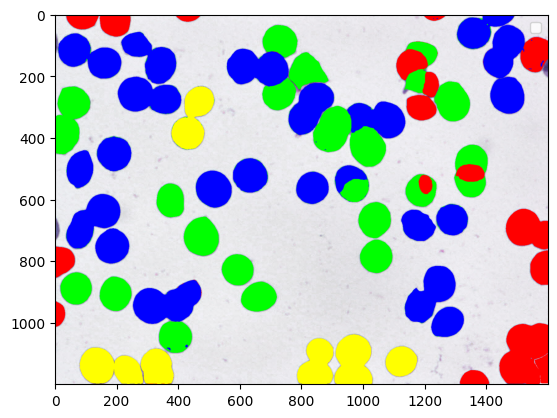

In [513]:
colored_image = kmeans_image_color_mapping(K_Means_center_assignment_array, image)

[0, 2]


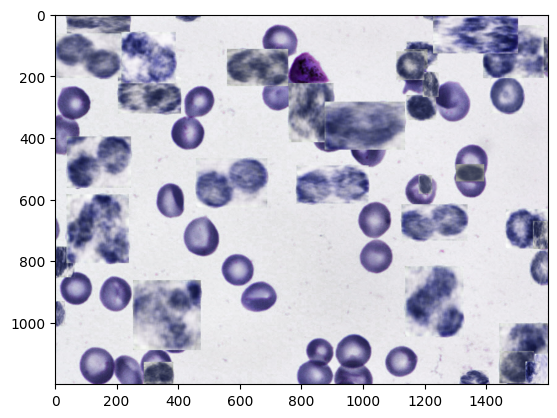

In [514]:
image_patched = patch_clustered_cells_with_VAE(image, bbox_list, K_Means_center_assignment_array, [0,2])
plt.imshow(image_patched)

## Drawing the ground bounding box in the analyzed image

{'bounding_box': {'minimum': {'r': 124, 'c': 758}, 'maximum': {'r': 241, 'c': 893}}, 'category': 'difficult'}


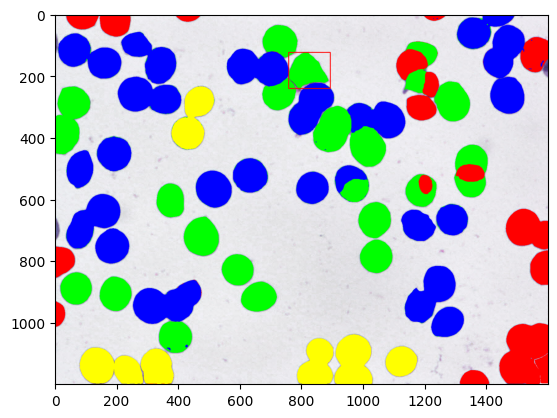

In [515]:
import json

# Opening JSON file
# f = open("/Users/yukuai/Documents/EN.580.637/Project_Shapley/code/my_code/malaria 2/training.json")
f_train = open(JSON_path+'training.json')
f_test = open(JSON_path+'testing.json')

plot_sick_cell(f_train, colored_image)
plot_sick_cell(f_test, colored_image)



In [516]:
cluster_excluded_all_list = excluded_list_generation(4)

In [517]:
shap_value_image_generation(image, bbox_list, K_Means_center_assignment_array, cluster_excluded_all_list)

[]
[0]
[1]
[2]
[3]
[0, 1]
[0, 2]
[0, 3]
[1, 2]
[1, 3]
[2, 3]
[0, 1, 2]
[0, 1, 3]
[0, 2, 3]
[1, 2, 3]
[0, 1, 2, 3]


In [518]:
# model_directory = 'prediction_model/'
# Load the classifier
filename = pt_path + 'model_git.pt'
model_git = torch.hub.load("pytorch/vision:v0.10.0", "resnet18", pretrained=False)
num_ftrs = model_git.fc.in_features
model_git.fc = nn.Linear(num_ftrs, 2)
model_git.load_state_dict(torch.load(filename, map_location=device))
model_git = model_git.to(device)
model_git.eval()
torch.cuda.empty_cache()
model_git = nn.Sequential(
    model_git,
    nn.Softmax(dim=1),
)
print(model_git)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [519]:
# calculate the Shapley Value
k_list = list(range(1,5))
shap_value_list = shap_main(k_list,shap_image_path, 4, model_git)

====================== looking at k=1
<PIL.Image.Image image mode=RGB size=1600x1200 at 0x7F18420A6710>


<ipython-input-510-6ba1681f57b7>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prep_img = torch.unsqueeze(torch.tensor(prep_img).float(), 0)


<PIL.Image.Image image mode=RGB size=1600x1200 at 0x7F18420A5D50>
<PIL.Image.Image image mode=RGB size=1600x1200 at 0x7F18420A6710>
<PIL.Image.Image image mode=RGB size=1600x1200 at 0x7F18420A7370>
<PIL.Image.Image image mode=RGB size=1600x1200 at 0x7F18420A6290>
<PIL.Image.Image image mode=RGB size=1600x1200 at 0x7F18420A6500>
<PIL.Image.Image image mode=RGB size=1600x1200 at 0x7F18420A7E50>
<PIL.Image.Image image mode=RGB size=1600x1200 at 0x7F18420A7DF0>
<PIL.Image.Image image mode=RGB size=1600x1200 at 0x7F18420A6D70>
<PIL.Image.Image image mode=RGB size=1600x1200 at 0x7F18420A5D50>
<PIL.Image.Image image mode=RGB size=1600x1200 at 0x7F18420A6D70>
<PIL.Image.Image image mode=RGB size=1600x1200 at 0x7F18420A7CA0>
<PIL.Image.Image image mode=RGB size=1600x1200 at 0x7F18420A5D50>
<PIL.Image.Image image mode=RGB size=1600x1200 at 0x7F18420A6500>
<PIL.Image.Image image mode=RGB size=1600x1200 at 0x7F18420A7DF0>
<PIL.Image.Image image mode=RGB size=1600x1200 at 0x7F18420A7D90>
the shap v

In [520]:
shap_value_list

[[1, -0.007732611770431201],
 [2, -0.029847075231373307],
 [3, -0.02110393267745773],
 [4, -0.011451795076330502]]

In [521]:
sam_matrix.shape

(134, 198369)

In [523]:
print(get_model_result(image, model_git))

0.0169124


<ipython-input-522-fb919875cd1c>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prep_img = torch.unsqueeze(torch.tensor(prep_img).float(), 0)
